# Classification tra cani e gatti utilizzando una CNN (Convolutional Neural  Network) 

## STEP 1:  Installazione dei packages (da fare solo una volta, altrimenti dà errore in pip install)

In [4]:
# STEP 1:  Install packages in the current environment
import sys
!{sys.executable} -m pip install opencv-python 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install scikit-learn
#pip install tensorflow
#pip install keras

## STEP 2:  Importare le dipendenze

In [5]:
import tensorflow as tf
import os
import cv2
import numpy as np
#import matplotlib.pyplot as plt
#import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#print out version of tensorflow using
print(tf.version.VERSION)

2.7.0


In [7]:
BASE_DIRECTORY ='C:\\Users\\pacifici\\OneDrive - Hewlett Packard Enterprise\\HPC\\solutioning\\AI\\'

base_dir = os.path.join(os.path.dirname(BASE_DIRECTORY), 'CNN-CatDog')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 100
IMG_SHAPE  = 150 

In [8]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [9]:
print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)

C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\train\cats
C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\train\dogs
C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\validation\cats
C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\validation\dogs


# Info 1: Calcolo del numero di campioni nel dataset (dimensioni del training dataset e validation dataset)

In [10]:
#show number of samples
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("total training samples = " +str(total_train))
print("total validation samples = " + str(total_val))

total training samples = 2000
total validation samples = 1000


# Info 2: Effettuare la data augmentation e lanciare la funzione per la grafica delle immagini 

### Funzione per mostrare alcune delle immagini dal dataset

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Data augmentation mediante horizontal flip

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


#### Visualizzare 5 immagini dopo la data augmentation (5 dal dataset)

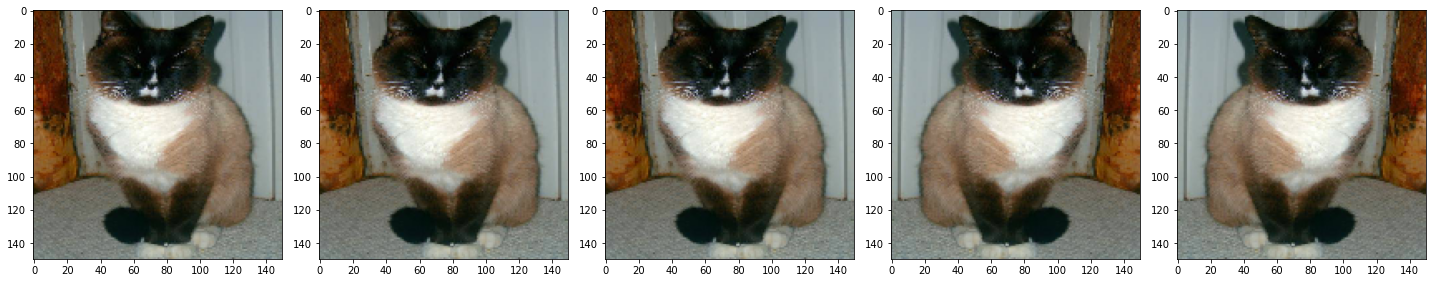

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Data augmentation mediante rotazione

In [17]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


#### Visualizzare 5 immagini dopo la data augmentation (5 dal dataset)

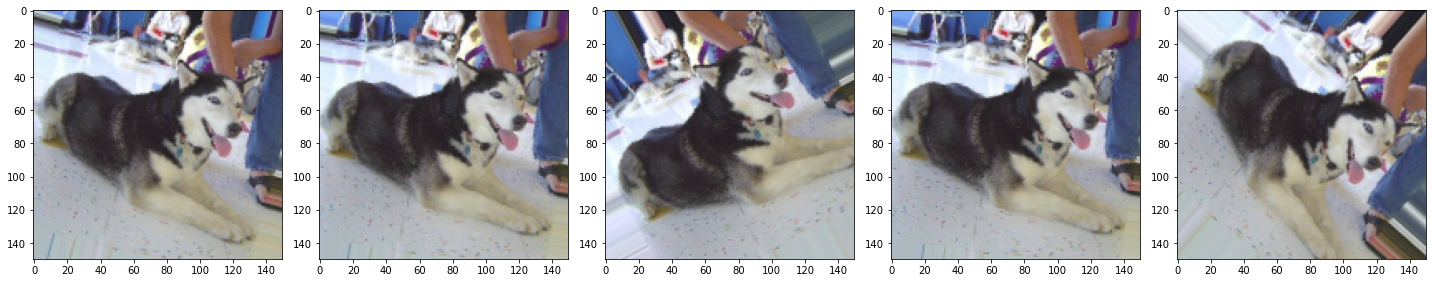

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Data augmentation mediante zoom

In [19]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


#### Visualizzare 5 immagini dopo la data augmentation (5 dal dataset)

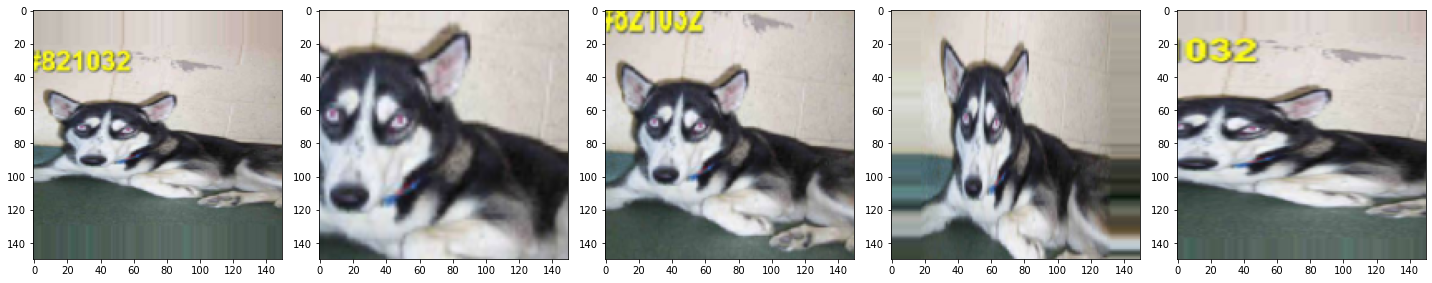

In [20]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## STEP 3:  Caricare il Training Dataset con l'aggiunta della data augmentation tramite  horizontal flip, rotazione, rescale, translazione, zoom, etc.

In [21]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


#### Visualizzare 5 immagini dopo la data augmentation (5 dal dataset)

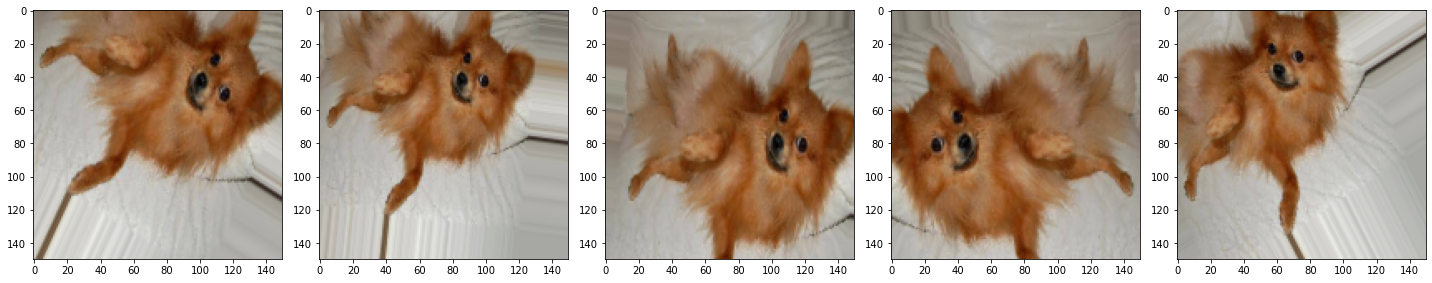

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## STEP 4: Caricare il Validation Data set utilizzando il Validaton Data Generator

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 shuffle=True,
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## STEP 5:  Creare il modello (rete CNN):   
##### 1) Input 150x150x3 (rescale to smaller) 
##### 2) Conv 32- 3x3 w/relu  
##### 3) MaxPooling 2x2    
##### 4) Conv 64-3x3 w/relu  
##### 5) MaxPooling 2x2   
##### 6) Conv 128-3x3 w/relu 
##### 7) MaxPooling 2x2   
##### 8) Conv 128-3x3 w/relu   
##### 9) MaxPooling 2x2     
##### 10) Dropout 0.5  
##### 11) Flatten for input to fully connected   
##### 12) Fully connected layer 512 w/relu     
##### 13) Softmax decision layer with output 2: [0 1]=dog, [1 0]=cat
### [1 0] è un gatto - [0 1] è un cane

In [24]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## STEP 6: Impostare i compile parameters per il model (optimizer adam; loss; accuracy)

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# STEP 7: Training del modello con solo 1 epoch

In [26]:
#setup tensorboard callback to collect info for use by tensorboard

mylog_dir = os.path.join( BASE_DIRECTORY, "CNN-CatDog\\train_log")
print("Mylog directory = " + mylog_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=mylog_dir, update_freq=1000)
print(os.path.join(mylog_dir, 'train'))

Mylog directory = C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\train_log
C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\train_log\train


In [28]:
epochs=1
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[tensorboard_callback]
)

<ipython-input-28-55bae8756793>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


20/20 [==============================] - 62s 3s/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6919 - val_accuracy: 0.5700


## STEP 8: Guardare i risultati

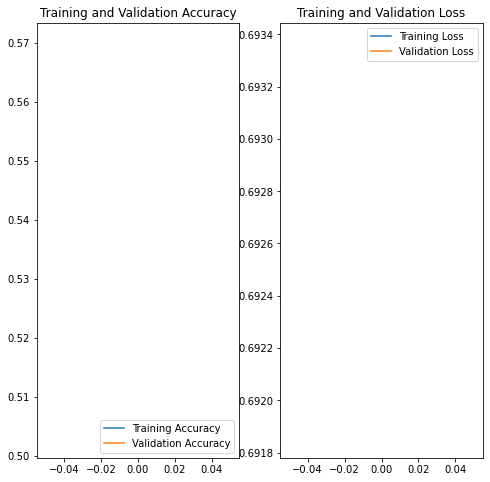

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## STEP 9:  Salvare il modello

In [30]:
model_file = os.path.join(BASE_DIRECTORY, 'CNN-CatDog\\catdog_1epoch_Luca.h5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save(model_file) 
print (BASE_DIRECTORY)

C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\


## STEP 11: Caricare (o usare) il modello appena trainato e salvato, per vederne l'architettura 

In [31]:
# try to reload the saved h5 file
# Recreate the exact same model, including its weights and the optimizer

model_file = os.path.join(BASE_DIRECTORY, 'CNN-CatDog\\catdog_1epoch_Luca.h5')
new_model = tf.keras.models.load_model(model_file)

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### OPTIONAL:  Mostra come caricare un modello un modello già salvato

In [32]:
saved_model_dir = os.path.join(BASE_DIRECTORY, 'CNN-CatDog\\saved_model\\catsdogsCNN_80')
# Note that it is going to use a pre trained model with 80epochs

print("Loading model from saved model at: " + str(saved_model_dir))

model = tf.keras.models.load_model(saved_model_dir)

# Check its architecture
model.summary()

Loading model from saved model at: C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\saved_model\catsdogsCNN_80
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34

## STEP 12: Prediction su una nuova immagine!
### [1 0] è un gatto - [0 1] è un cane


In [33]:
#function to load a single image
def loadAndSizeAndScaleImage(filename):
    print("loadAndSizeImage:  loading file " + str(filename))
    img = cv2.imread(filename)
    #print(img)
    print("loadAndSizeImage: original size " + str(img.shape))
    #change size if needed
    newimg = cv2.resize(img,(IMG_SHAPE, IMG_SHAPE))
    print("loadAndSizeImage: new size " + str(newimg.shape))
    #now rescale the image as we are using ImageDataGenerator with rescale=1./255
    print("start rescale")
    newimg = np.array(newimg).astype('float32')/255
    #print("loadAndSizeImage:  rescaling values /255")
    #print(newimg)
    return newimg


In [36]:
#function to explicitate if dog or cat
def isDogOrCat(prediction):
    isCat=round(float(prediction[0].tolist()[0]*100),2)
    isDog=round(float(prediction[0].tolist()[1]*100),2)
    if isCat > 50:
     print(testImg+" è un GATTO")
    else:
     print(testImg+" è un CANE")
    print(isCat,"% GATTO",isDog,"% CANE")


In [37]:
# make prediction on a simgle image

#first load image

testImg = os.path.join(BASE_DIRECTORY, 'CNN-CatDog\\test\\carota1.jpg')

print("Loading " + str(testImg))
img = loadAndSizeAndScaleImage(testImg)

##debug
#print("image shape is " + str(img.shape))
#print(img)



#setup input tensor  of shape (batch=1, height, width, channels) = (1, 150,150,3)
tensor_input = np.expand_dims(img,axis=0)
#print("tensor shape is " + str(tensor_input.shape))
#print(tensor_input)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions ')
#predictions = model.predict_generator(val_data_gen, verbose=1 )
prediction = model.predict(tensor_input)
isDogOrCat(prediction)


Loading C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\test\carota1.jpg
loadAndSizeImage:  loading file C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\test\carota1.jpg
loadAndSizeImage: original size (726, 1024, 3)
loadAndSizeImage: new size (150, 150, 3)
start rescale

# Generate predictions 
C:\Users\pacifici\OneDrive - Hewlett Packard Enterprise\HPC\solutioning\AI\CNN-CatDog\test\carota1.jpg è un GATTO
99.82 % GATTO 0.18 % CANE
